In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from slicer_generation import *
from surface_solns import *
from custom_slicer_helpers import *

In [2]:
%matplotlib ipympl

In [3]:
def make_sample_txt(p, fn_out="custom_mirror_array_params_0.txt"):
    """Make a sample txt file for loading slice parameters.
    
    Parameters
    ----------
    p: ImageSliceParams
        Parameter file to use to create the sample txt file.
    fn_out: str
        Filename to write the sample txt file to.

    Returns
    -------
    arr:

    """
    f = open(fn_out, "w")
    n_slices_per_col = p.n_each * p.n_rows
    f.write(f"{n_slices_per_col} {p.n_cols} {p.cylinder}\n")
    f.write(f"{p.dx} {p.dy} {p.gx_width} {p.gx_depth} {p.gy_width} {p.gy_depth}\n")
    
    for col_num in range(p.n_cols):
        for slice_num in range(n_slices_per_col):
            alpha, beta, gamma, c, k = get_slice_params_standard(slice_num, col_num, p)
            f.write(f"{alpha} {beta} {gamma} {c} {k}\n")
    f.close()
#make_sample_txt(p)

In [173]:
def check_slice_solution(tol, ray_in, ns_test, nc_test, p, custom_slice_params):
    """

    Returns
    -------
    ray_out: RayOut
        Output ray parameters. Values are nan if the ray missed.
    """

    ray_out = RayOut(np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
    xt, yt = ray_in.xt, ray_in.yt
    l, m, n = ray_in.l, ray_in.m, ray_in.n

    # Check if this slice is a solution. Get params for this slice and
    # compute the transfer distance.
    pslice = get_slice_params(ns_test, nc_test, p, custom_slice_params)
    sag_func, transfer_dist_func, surf_normal_func, _ = get_surface_funcs(pslice.c, p)

    t = transfer_dist_func(xt, yt, l, m, n, pslice)
    result = transfer_equation(t, xt, yt, l, m, n, p, custom_slice_params)

    # Is this a valid zero to the transfer equation?
    if abs(result) < tol:
        # Yes - found a solution!
        xs = xt + t*l
        ys = yt + t*m
        zs = t*n
        ln, mn, nn = surf_normal_func(xs, ys, pslice, True)

        # WAIT - Is the solution inside of a gap? If we're unlucky and zs is
        # equal to the gap depth then this may be the case.
        in_xgap, in_ygap = is_inside_slicer_gap(xs, ys, p, custom_slice_params)
        if (in_xgap or in_ygap):
            return ray_out
        
        # Not in a gap. This slice is the solution.
        ray_out.xs, ray_out.ys, ray_out.zs, ray_out.t = xs, ys, zs, t
        ray_out.ln, ray_out.mn, ray_out.nn = ln, mn, nn
        return ray_out
    
    return ray_out

In [226]:
is_section_in_bounds(3,0, umin, umax, p, custom_slice_params)

True

In [270]:
def calc_num_slices_to_check(ray_in, nc_test, nr_test, sgnc, sgns, x_test, y_test, p):
    """

    Returns
    -------
    n_stocheck: int
        Number of slices to check in this section.∂
    x_testnew: float
    """
    xt, yt = ray_in.xt, ray_in.yt
    l, m, n = ray_in.l, ray_in.m, ray_in.n

    # Ray in coming in straight-on in the z-direction. No need to change sections.
    if (abs(l) < 1e-13 and abs(m) < 1e-13):
        return 1, nc_test, nr_test, x_test, y_test
    
    # Avoid division by zero. Doesn't matter what exactly we set this to because
    # the non-infinitesimal value of l or m will win out.
    l = max(abs(l), 1e-13)
    m = max(abs(m), 1e-13)

    xsize, ysize = get_slicer_size(p)
    
    # x- and y-coordinates of crossover points to the next section, incremented
    # either column- or row-wise.
    x_nextcol = (nc_test + (1 + sgnc) / 2) * (p.dx + p.gx_width) - xsize / 2
    y_nextcol = yt + (x_nextcol - x_test) * m / l

    y_nextrow = (nr_test + (1 + sgns) / 2) * p.n_each * (p.dy + p.gy_width) - ysize / 2
    print(f"ynextrow is {y_nextrow}")
    print(p.dy, ysize)
    x_nextrow = xt + (y_nextrow - y_test) * l / m

    # Whether the next section is incremented column- or row-wise depends on which
    # distance is smaller
    dtocol = np.sqrt((x_nextcol - x_test)**2 + (y_nextcol - y_test)**2)
    dtorow = np.sqrt((x_nextrow - x_test)**2 + (y_nextrow - y_test)**2)

    print("distances are")
    print(dtocol, dtorow)

    if dtocol <= dtorow:
        # Crossing columns. Cap the number of slices to check to the number of slices
        # within a single section, but always check at least 1.
        n_stocheck = math.ceil(abs(y_nextcol - y_test) / (p.dy + p.gy_width))
        n_stocheck = max( min(n_stocheck, p.n_each), 1 )
        nc_new = nc_test + sgnc
        nr_new = nr_test
        return n_stocheck, nc_new, nr_new, x_nextcol, y_nextcol
    else:
        # Crossing rows, same logic
        n_stocheck = math.ceil(abs(y_nextrow - y_test) / (p.dy + p.gy_width))
        n_stocheck = max( min(n_stocheck, p.n_each), 1 )
        nc_new = nc_test
        nr_new = nr_test + sgns
        return n_stocheck, nc_new, nr_new, x_nextrow, y_nextrow

def ray_trace_slicer(ray_in, zmin, zmax, umin, umax, trace_walls, p, custom_slice_params):
    """
    """
    # Tolerance for accepting the transfer distance as valid
    tol = 1e-12
    ray_out = RayOut(np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    # Get starting and ending rows and columns
    nc_min, ns_min, nc_max, ns_max, sgnc, sgns = get_ray_bounds(ray_in, zmin, zmax, p, custom_slice_params)
    if not is_ray_in_bounds(nc_min, ns_min, nc_max, ns_max, umin, umax, p):
        return ray_out
    # Ray is in bounds at least some of the time. Start from the min col and slice
    # indices and check solutions until we hit the max
    nc_test, ns_test = nc_min, ns_min
    nr_test = ns_test // p.n_each

    x_test, y_test = ray_in.xt, ray_in.yt
    print(nc_test, ns_test)
    # If starting index isn't in bounds, set it to where it will be in bounds
    while not is_section_in_bounds(nc_test, nr_test, umin, umax, p, custom_slice_params):
        n_stocheck, nc_test, nr_test, x_test, y_test = calc_num_slices_to_check(ray_in, nc_test, nr_test, sgnc, sgns, x_test, y_test, p)
        ns_test = nr_test * p.n_each

    while is_section_in_bounds(nc_test, nr_test, umin, umax, p, custom_slice_params):
        print("here")
        # Number of slices to check in this section
        n_stocheck, nc_test_new, nr_test_new, x_test, y_test = calc_num_slices_to_check(ray_in, nc_test, nr_test, sgnc, sgns, x_test, y_test, p)
        print(nc_test, nr_test)
        print(nc_test_new, nr_test_new)
        # Iterate slices within this section
        for n in range(n_stocheck):
            print(ns_test)
            # Check whether each slice is a solution to the transfer equation
            ray_out = check_slice_solution(tol, ray_in, ns_test, nc_test, p, custom_slice_params)
            if not np.isnan(ray_out.t):
                # Found a solution with a slice.
                return ray_out

            # Before going to the next slice, check if there is a collision with
            # a wall. (Skip if this is the last slice in the section.)
            if (trace_walls and n < n_stocheck - 1):
                ray_out = check_ywall_collision(ray_in, ns_test, nc_test, sgns, p, custom_slice_params)
                if not np.isnan(ray_out.t):
                    # Found a wall collision.
                    return ray_out
            
            # Increment the slice index
            ns_test += sgns
        
        # Need to double check the last slice index in the next section
        ns_test -= 1

        # Before continuing, check walls between sections. (Skip if this is the
        # last section to check.)
        if ( trace_walls and is_section_in_bounds(nc_test_new, nr_test_new, umin, umax, p, custom_slice_params) ):

            # Section changed columns, check collision with x-wall
            if nc_test_new != nc_test:
                ray_out = check_xwall_collision(ray_in, ns_test, nc_test, sgnc, p, custom_slice_params)
                if not np.isnan(ray_out.t):
                    # Found a wall collision.
                    return ray_out
                
            # Must have changed rows instead. Check collision with y-wall
            else:
                ray_out = check_ywall_collision(ray_in, ns_test, nc_test, sgns, p, custom_slice_params)
                if not np.isnan(ray_out.t):
                    # Found a wall collision.
                    return ray_out
                
        nc_test = nc_test_new
        nr_test = nr_test_new
    
    # If none of the above worked then we probably hit a gap
    if trace_walls:
        ray_out = check_gap_collision(tol, ray_in, p, custom_slice_params)
        if not np.isnan(ray_out.t):
            # Found a gap collision.
            return ray_out

    # If none of that worked then this is a bizarre edge case, e.g., the direction cosine is less than 1E-13
    # but it grazed off of a wall somehow. Sweep this ray under the rug and say that it missed...
    # ray_out will be filled with NaN values at this point.
    return ray_out    # Phew!

In [257]:
is_section_in_bounds(3, 1, umin, umax, p, custom_slice_params)

False

In [119]:
get_slicer_index(xt, yt, p, custom_slice_params)

(1.0, 2.0)

In [221]:
check_slice_solution(1e-12, ray_in, 1, 1, p, custom_slice_params)

-2.5626260743373215


RayOut(xs=np.float64(-9.802566270009239), ys=np.float64(0.0), zs=np.float64(-1.318460237994457), t=np.float64(-2.5626260743373215), ln=np.float64(0.21174728308477286), mn=np.float64(-0.0), nn=np.float64(-0.9773244538566591))

3.0 1.0
here
ynextrow is 4.0
4 8
distances are
18.0 33442224102789.227
3.0 0.0
2.0 0.0
1.0
-0.31587450001720957
here
ynextrow is 4.0
4 8
distances are
11.0 33442224102753.227
2.0 0.0
1.0 0.0
1.0
-1.3459815636801968
here
ynextrow is 4.0
4 8
distances are
11.0 33442224102793.23
1.0 0.0
0.0 0.0
1.0
-2.5627664096197598
analytic soln: -2.5627664096197598
numerical soln:-2.57314629258517


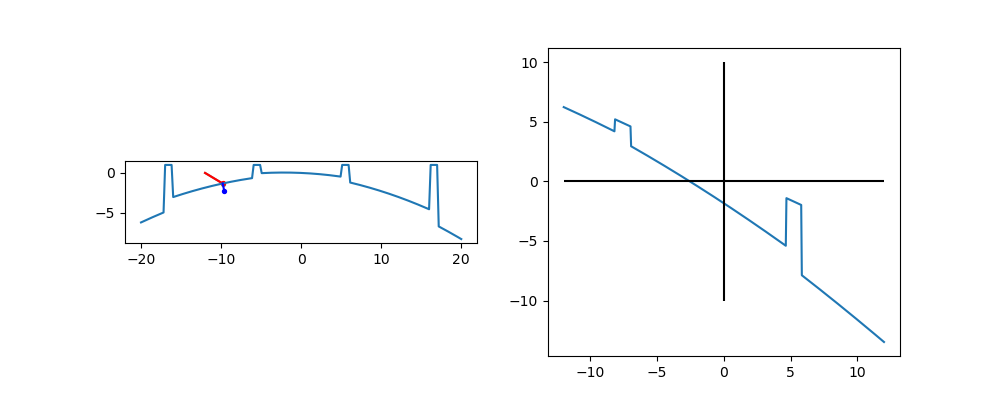

In [271]:
p = ImageSlicerParams(
    custom = False,
    surface_type = 0,
    n_each = 2,
    n_rows = 1,
    n_cols = 5,
    angle_mode = 0,
    dalpha = 0,
    dbeta = -8,
    dgamma = 5,
    gamma_offset = 0,
    dzp_col = 0,
    dzp_row = 0,
    dsyx = 0,
    dsyz = 0,
    dsxy = 0,
    dsxz = 0,
    du = 0,
    alpha_cen = 0,
    beta_cen = 0,
    gamma_cen = 0,
    zp_cen = 0,
    syx_cen = 0,
    syz_cen = 0,
    sxy_cen = 0,
    sxz_cen = 0,
    u_cen = 0,
    dx = 10,
    dy = 4,
    c = -1/50,
    k = -1.2,
    gx_width = 1,
    gx_depth = 1,
    gy_width = 0,
    gy_depth = 0
)

trace_walls = True
custom_slice_params = np.array([])

yt = 0.1
x = np.linspace(-20, 20, 200)
surf = np.zeros(len(x))
for i,x1 in enumerate(x):
    surf[i] = make_image_slicer(x1, yt, p, custom_slice_params)

xt = -12
l = -1.
m = 0.0
n = 0.6

#xt = -5
#l = 0.2
#m =  0
#n = 0.8
norm = np.sqrt(l*l+m*m+n*n)
l /= norm
m /= norm
n /= norm

ray_in = RayIn(xt, yt, l, m, n)

zmin, zmax = find_global_extrema_slicer(p, custom_slice_params)
umin, umax = get_min_max_u(p, custom_slice_params)
ray_out = ray_trace_slicer(ray_in, zmin, zmax, umin, umax, trace_walls, p, custom_slice_params)
print("analytic soln: " + str(ray_out.t))

t = np.linspace(-12, 12, 500)
feval = np.zeros(len(t))
for i,t1 in enumerate(t):
    feval[i] = transfer_equation(t1, xt, yt, l, m, n, p, custom_slice_params)
idx = np.nanargmin(np.abs(feval))
tnum = t[idx]
print("numerical soln:" + str(tnum))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].plot(x, surf)

# Draw analytically calculated ray and surface normal
axs[0].plot([ray_in.xt, ray_out.xs], [0, ray_out.zs], c='r', zorder=1)
axs[0].scatter([ray_out.xs], [ray_out.zs], c='r', s=8, zorder=1)
axs[0].plot([ray_out.xs, ray_out.xs + ray_out.ln], [ray_out.zs, ray_out.zs + ray_out.nn], c='b')
axs[0].scatter([ray_out.xs + ray_out.ln], [ray_out.zs + ray_out.nn], c='b', s=8, zorder=10)

# Numerically determined ray
axs[0].plot([ray_in.xt, ray_in.xt + tnum*ray_in.l], [0, tnum*ray_in.n], c='gray', zorder=0)
axs[0].scatter([ray_in.xt + tnum*ray_in.l], [tnum*ray_in.n], c='gray', s=8, zorder=0)

axs[0].set_aspect("equal")

axs[1].plot(t, feval)
axs[1].hlines(0, t[0], t[-1], colors='k')
axs[1].vlines(0, -10, 10, colors='k')
#axs[1].set_ylim(np.nanmin(feval), np.nanmax(feval))

plt.show()

nan
nan
-4.907075213700057
analytic soln: -4.907075213700057
numerical soln:-4.929859719438878


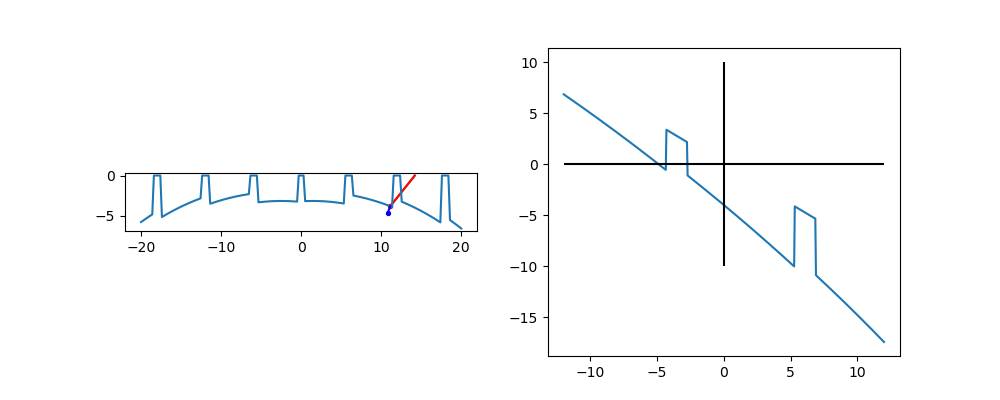

In [95]:
p = ImageSlicerParams(
    custom = 0,
    surface_type = 0,
    n_each = 5,
    n_rows = 2,
    n_cols = 3,
    angle_mode = 0,
    dalpha = -15,
    dbeta = 2,
    dgamma = 10,
    gamma_offset = 0,
    dzp_col = 0,
    dzp_row = 0,
    dsyx = 0,
    dsyz = 0,
    dsxy = 0,
    dsxz = 0,
    du = 0,
    alpha_cen = 2,
    beta_cen = -7,
    gamma_cen = 4,
    zp_cen = 0,
    syx_cen = 0,
    syz_cen = 0,
    sxy_cen = 0,
    sxz_cen = 0,
    u_cen = 0,
    dx = 10,
    dy = 5,
    c = -1/30,
    k = 0,
    gx_width = 0,
    gx_depth = 0,
    gy_width = 1,
    gy_depth = 0
)

trace_walls = True
custom_slice_params = np.array([])

xt = 5
y = np.linspace(-20, 20, 200)
surf = np.zeros(len(y))
for i,y1 in enumerate(y):
    surf[i] = make_image_slicer(xt, y1, p, custom_slice_params)


yt = 14.2
l = 0
m = 0.8
n = 1
norm = np.sqrt(l*l+m*m+n*n)
l /= norm
m /= norm
n /= norm

ray_in = RayIn(xt, yt, l, m, n)
ray_out = RayOut(0, 0, 0, 0, 0, 0, 0)

zmin, zmax = find_global_extrema_slicer(p, custom_slice_params)
umin, umax = get_min_max_u(p, custom_slice_params)
ray_out = ray_trace_slicer(ray_in, zmin, zmax, umin, umax, trace_walls, p, custom_slice_params)
print("analytic soln: " + str(ray_out.t))

t = np.linspace(-12, 12, 500)
feval = np.zeros(len(t))
for i,t1 in enumerate(t):
    feval[i] = transfer_equation(t1, xt, yt, l, m, n, p, custom_slice_params)
idx = np.nanargmin(np.abs(feval))
tnum = t[idx]
print("numerical soln:" + str(tnum))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].plot(y, surf)

# Draw analytically calculated ray and surface normal
axs[0].plot([ray_in.yt, ray_out.ys], [0, ray_out.zs], c='r', zorder=1)
axs[0].scatter([ray_out.ys], [ray_out.zs], c='r', s=8, zorder=1)
axs[0].plot([ray_out.ys, ray_out.ys + ray_out.mn], [ray_out.zs, ray_out.zs + ray_out.nn], c='b')
axs[0].scatter([ray_out.ys + ray_out.mn], [ray_out.zs + ray_out.nn], c='b', s=8, zorder=10)

# Numerically determined ray
axs[0].plot([ray_in.yt, ray_in.yt + tnum*ray_in.m], [0, tnum*ray_in.n], c='gray', zorder=0)
axs[0].scatter([ray_in.yt + tnum*ray_in.m], [tnum*ray_in.n], c='gray', s=8, zorder=0)

axs[0].set_aspect("equal")

axs[1].plot(t, feval)
axs[1].hlines(0, t[0], t[-1], colors='k')
axs[1].vlines(0, -10, 10, colors='k')
#axs[1].set_ylim(np.nanmin(feval), np.nanmax(feval))

plt.show()

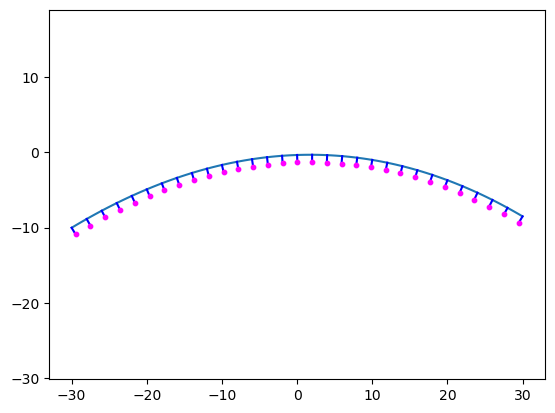

In [11]:
#sag_func = tilted_plane_sag
#surface_norm_func = tilted_plane_surface_normal
sag_func = conic_3d_sag
surface_norm_func = conic_3d_surface_normal

xs = np.linspace(-30,30,100)
r = 50
c = -1/r
k = -1
alpha = 11
beta = 10
gamma = 3

surface = sag_func(xs, y0, c, k, alpha, beta, gamma)

#print(conic_3d_sag_critical_x_y(c, k, 0, 2, gamma))


#idx = np.argmin(surface)
#print(xs[idx])

plt.figure()
plt.plot(xs, surface)

for xtest in np.arange(-30, 30.1, 2):
    nx, ny, nz = surface_norm_func(xtest, y0, c, k, alpha, beta, gamma)
    ztest = sag_func(xtest, y0, c, k, alpha, beta, gamma)
    plt.plot([xtest, xtest+nx], [ztest, ztest+nz], c='b')
    plt.scatter([xtest+nx], [ztest+nz], c='fuchsia', s=10, zorder=10)
    #plt.plot([xtest, xtest-c*xtest], [ztest, ztest+1-c*ztest], c='r')
plt.plot()
plt.axis("equal")
#plt.plot([xtest, xtest-c*xtest], [ztest, ztest+1-c*ztest], c='r')
#plt.ylim(-1,4)
#plt.scatter(xs[idx], surface[idx], c='r')
plt.show()

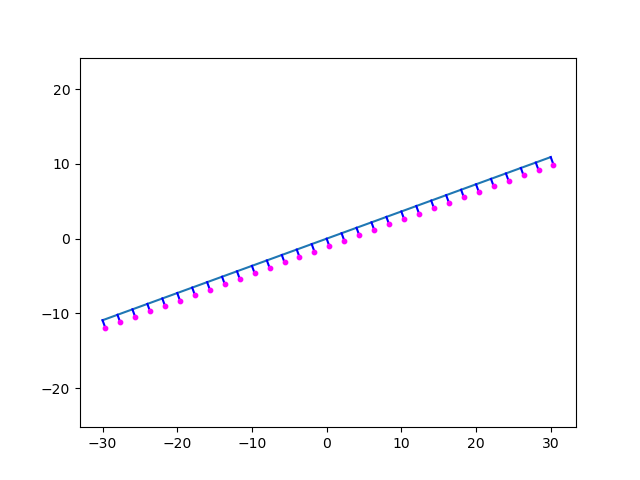

In [47]:
ys = np.linspace(-30,30,100)
x0 = 0

surface = sag_func(x0, ys, c, k, alpha, beta, gamma)

plt.figure()
plt.plot(ys, surface)

for ytest in np.arange(-30, 30.1, 2):
    nx, ny, nz = surface_norm_func(x0, ytest, c, k, alpha, beta, gamma)
    ztest = sag_func(x0, ytest, c, k, alpha, beta, gamma)
    plt.plot([ytest, ytest+ny], [ztest, ztest+nz], c='b')
    plt.scatter([ytest+ny], [ztest+nz], c='fuchsia', s=10, zorder=10)
    #plt.plot([ytest, ytest-c*ytest], [ztest, ztest+1-c*ztest], c='r'
plt.axis("equal")
plt.show()

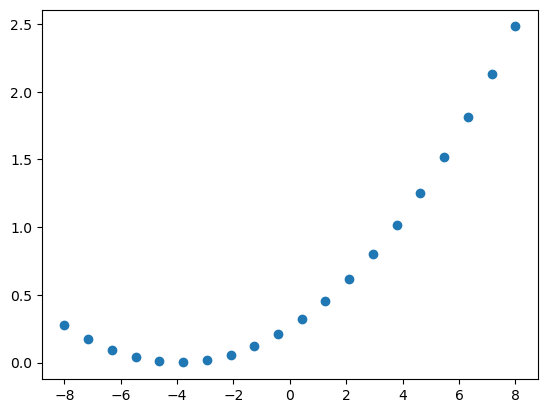

In [8]:
n_each = 1
n_rows = 1
n_cols = 1
mode = 0
trace_walls = True
active_x = False
active_y = False
dalpha = -0
dbeta = 0
dgamma = 0
alpha_cen = 0
beta_cen = 15
gamma_cen = 0
dx = 15
dy = 5
r = 30
c = 1/r
k = -1
gx_width = 0
gx_depth = np.nan
gy_width = 0
gy_depth = np.nan
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, trace_walls, active_x, active_y, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, gx_width, gx_depth, gy_width, gy_depth)

N = 20
r = 20
k = 0
t = -10

y = np.linspace(-8, 8, N)
x = np.linspace(-8, 8, N)
z = conic_3d_sag(x, 0, c, k, alpha_cen, beta_cen, 0)

plt.figure()
plt.scatter(x, z)
plt.show()

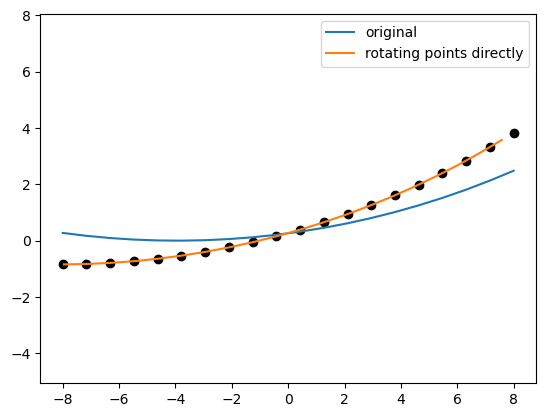

In [10]:
beta_cen= 15
t=-8
def conic(x,c,k,beta):
    beta *= np.pi/180
    x0 = np.sin(beta) / c / (1 + np.cos(beta))
    x += x0
    return c*x*x / (1 + np.sqrt(1-(1+k)*c*c*x*x))

N = 20

# perform the rotation manually with a rotation matrix
x1 = np.linspace(-8, 8, N)
y1 = []
x2 = []
y2 = []
#y3 = []
trad = -t*np.pi/180

for i in range(N):
    y1.append(conic(x1[i],c,k,beta_cen))
    xnew = x1[i]*np.cos(trad)-y1[i]*np.sin(trad)
    ynew = x1[i]*np.sin(trad)+y1[i]*np.cos(trad)
    x2.append(xnew)
    y2.append(ynew)
    #y3.append(rotated_conic(x1[i], r, k, t))

y3 = conic_3d_sag(x1, 0, c, k, alpha_cen, beta_cen, t)
plt.figure()
plt.plot(x1,y1,label='original')
plt.plot(x2,y2,label='rotating points directly')
plt.scatter(x1,y3,c='k')
#plt.vlines([-2,0,2], -1, 1)
#plt.ylim(0,8)
#plt.xlim(-8,8)
plt.axis('equal')
plt.legend()
#plt.savefig("rotated_conics.png",dpi=300,facecolor="white")
plt.show()

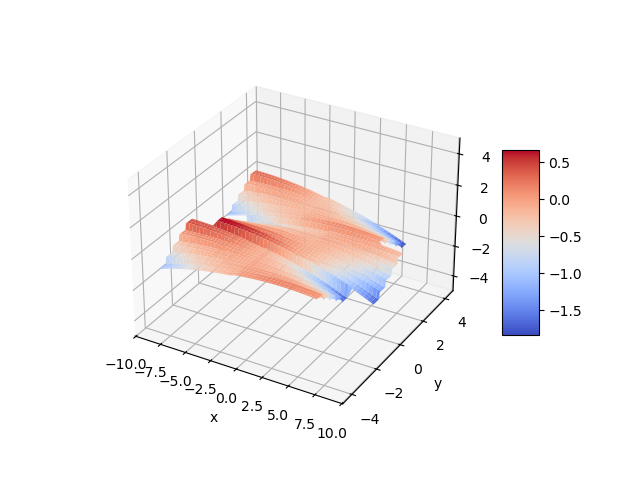

In [13]:
p = ImageSlicerParams(
    custom = 0,
    surface_type = 0,
    n_each = 5,
    n_rows = 3,
    n_cols = 2,
    angle_mode = 2,
    dalpha = -3,
    dbeta = 3,
    dgamma = 3,
    gamma_offset = 1.5,
    dzp_col = 0,
    dzp_row = 0,
    dsyx = 0,
    dsyz = 0,
    dsxy = 0,
    dsxz = 0,
    du = 3,
    alpha_cen = 4,
    beta_cen = -5,
    gamma_cen = 0,
    zp_cen = 0,
    syx_cen = 0,
    syz_cen = 0,
    sxy_cen = 0,
    sxz_cen = 0,
    u_cen = 0,
    dx = 8,
    dy = 0.5,
    c = -1/50,
    k =0,
    gx_width = 0,
    gx_depth = -3,
    gy_width = 0,
    gy_depth = 2
)
custom_slice_params = np.array([])
xsize, ysize = get_slicer_size(p)

N = 200

#Nx = n_cols * 8
#Ny = n_rows * n_each * 8
x = np.linspace(-1.1*xsize/2,1.1*xsize/2,N)
y = np.linspace(-1.1*ysize/2,1.1*ysize/2,N)

Z = np.zeros((N,N))
for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        Z[j,i]=make_image_slicer(x1, y1, p, custom_slice_params)
        #Z[i,j]=make_image_slicer2(x1, y1, n_each, dalpha, dbeta, alpha_cen, beta_cen, dx, dy, rx, ry, kx, ky)
    

X, Y = np.meshgrid(x, y)
#Z2 = make_slice(X, Y, rx, ry, kx, ky, 0, 0)

#zmin, zmax = find_global_extrema_slicer(p, sag_func, critical_xy_func)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
#ax.plot_surface(X,Y,np.ones((N,N))*zmin, alpha=0.3)
#ax.plot_surface(X,Y,np.ones((N,N))*zmax, alpha=0.3)
#surf = ax.plot_surface(X, Y, Z2, cmap=cm.viridis)
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(azim=90, elev=0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(-5, 5)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [4]:
custom_slice_params = load_slice_params_file(1)
p = make_image_slicer_params_from_custom(custom_slice_params)

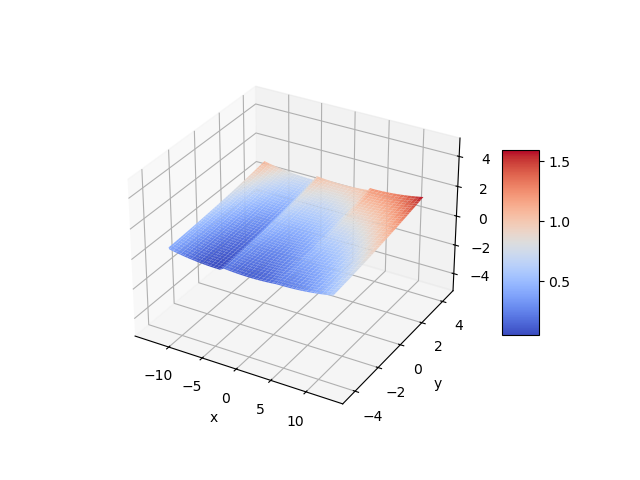

In [7]:
xsize, ysize = get_slicer_size(p)

N = 500

#Nx = n_cols * 8
#Ny = n_rows * n_each * 8
x = np.linspace(-1.1*xsize/2,1.1*xsize/2,N)
y = np.linspace(-1.1*ysize/2,1.1*ysize/2,N)

Z = np.zeros((N,N))
for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        Z[j,i]=make_image_slicer(x1, y1, p, custom_slice_params)
        #Z[i,j]=make_image_slicer2(x1, y1, n_each, dalpha, dbeta, alpha_cen, beta_cen, dx, dy, rx, ry, kx, ky)
    

X, Y = np.meshgrid(x, y)
#Z2 = make_slice(X, Y, rx, ry, kx, ky, 0, 0)

#zmin, zmax = find_global_extrema_slicer(p, sag_func, critical_xy_func)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
#ax.plot_surface(X,Y,np.ones((N,N))*zmin, alpha=0.3)
#ax.plot_surface(X,Y,np.ones((N,N))*zmax, alpha=0.3)
#surf = ax.plot_surface(X, Y, Z2, cmap=cm.viridis)
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(azim=90, elev=0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(-5, 5)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()